<h1>Classification of Lung Cancer in Images Using LBP Feature Extraction



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import cv2
import imutils

import warnings

#filter future warning message
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Preparation

> take data from kaggle then put it into google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Lung_Cancer/dataset'

> create and read the metadata that will be used

In [ ]:
metadata = pd.DataFrame(columns=['image_path', 'segmented_image', 'label'])
metadata

,image_path,segmented_image,label


# Preprocessing and Segmentation

> create functions for preprocessing to grayscale and image segmentation using the otsu method

In [ ]:


def crop_img(img):

    """
    Finds the lung region in the image and crops it
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image to create a binary mask
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours of the lung region
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask of the lung region
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    # Find bounding box of the lung region
    x, y, w, h = cv2.boundingRect(mask)

    # Crop the lung region from the original image
    cropped_img = masked_img[y:y+h, x:x+w]

    return cropped_img


In [ ]:

def crop_img(img):
    """
    Finds the lung region in the image and crops it
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image to create a binary mask
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours of the lung region
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    max_area = -1
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour

    # Create a mask of the lung region
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    # Find bounding box of the lung region
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the lung region from the original image
    cropped_img = masked_img[y:y+h, x:x+w]

    return cropped_img


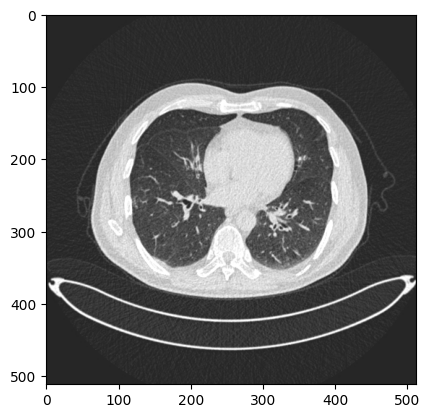

In [ ]:
img8=plt.imread('/content/drive/MyDrive/Lung_Cancer/dataset/Benign/Bengin case (10).jpg')
plt.imshow(img8)

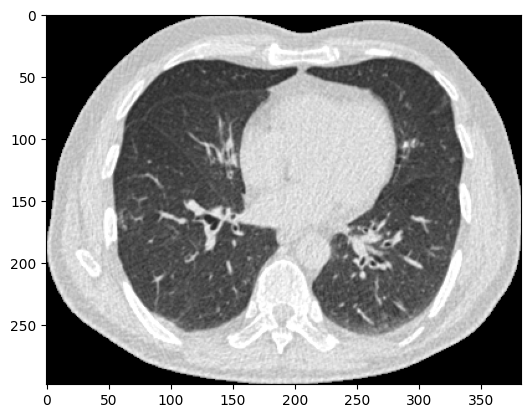

In [ ]:

img9=crop_img(img8)

plt.imshow(img9)

In [ ]:
def segment_image(image):
  gray_image = rgb2gray(image)
  gray_image=cv2.GaussianBlur(gray_image,(3,3),0)
  cropped_img= crop_img(gray_image)
  # prepro_img= preprocess_img(gray_image)
  # threshold = threshold_otsu(prepro_img)
  # segmented_image = gray_img > threshold
  threshold = threshold_otsu(gray_image)
  segmented_image = gray_image > threshold

  return segmented_image

In [ ]:
def segment_image(image):
  preprocess_img= crop_img(image)
  gray_image = rgb2gray(preprocess_img)
  gray_image=cv2.GaussianBlur(gray_image,(3,3),0)
  threshold = threshold_otsu(gray_image)
  segmented_image = gray_image > threshold

  return segmented_image

> inserting images from folder no and folder yes into metadata after the image has been segmented

In [ ]:
metadata_list = []
Benign_folder = os.path.join(dataset_path, 'Benign')
Benign_images = os.listdir(Benign_folder)

for image_name in Benign_images:
  image_path = os.path.join(Benign_folder, image_name)
  image = plt.imread(image_path)
  image_shape = image.shape
  if (image_shape[-1] !=3 or len(image_shape) !=3):
      continue
  #image=cv2.GaussianBlur(image,(3,3),0)
  segmented_image = segment_image(image)
  metadata_list.append(pd.DataFrame({'image_path': [image_path], 'segmented_image': [segmented_image], 'label': ['Benign']}))

# Concatenate all dataframes in the list
metadata = pd.concat(metadata_list, ignore_index=True)

In [ ]:
metadata_list_2 = []
Malignant_folder = os.path.join(dataset_path, 'Malignant')
Malignant_images = os.listdir(Malignant_folder)

for image_name in Malignant_images:
  image_path = os.path.join(Malignant_folder, image_name)
  image = plt.imread(image_path)
  image_shape = image.shape
  if (image_shape[-1] !=3 or len(image_shape) !=3):
      continue
  #image=cv2.GaussianBlur(image,(3,3),0)
  segmented_image = segment_image(image)
  metadata_list.append(pd.DataFrame({'image_path': [image_path], 'segmented_image': [segmented_image], 'label': ['Malignant']}))

# Concatenate all dataframes in the list
metadata = pd.concat(metadata_list, ignore_index=True)

In [ ]:
metadata_list_3 = []
Normal_folder = os.path.join(dataset_path, 'Normal')
Normal_images = os.listdir(Normal_folder)

for image_name in Normal_images:
  image_path = os.path.join(Normal_folder, image_name)
  image = plt.imread(image_path)
  image_shape = image.shape
  if (image_shape[-1] !=3 or len(image_shape) !=3):
      continue
 # image=cv2.GaussianBlur(image,(3,3),0)
  segmented_image = segment_image(image)
  metadata_list.append(pd.DataFrame({'image_path': [image_path], 'segmented_image': [segmented_image], 'label': ['Normal']}))

# Concatenate all dataframes in the list
metadata = pd.concat(metadata_list, ignore_index=True)

In [ ]:
metadata

,image_path,segmented_image,label
0,/content/drive/MyDrive/Lung_Cancer/dataset/Ben...,"[[False, False, False, False, False, False, Fa...",Benign
1,/content/drive/MyDrive/Lung_Cancer/dataset/Ben...,"[[False, False, False, False, False, False, Fa...",Benign
2,/content/drive/MyDrive/Lung_Cancer/dataset/Ben...,"[[False, False, False, False, False, False, Fa...",Benign
3,/content/drive/MyDrive/Lung_Cancer/dataset/Ben...,"[[False, False, False, False, False, False, Fa...",Benign
4,/content/drive/MyDrive/Lung_Cancer/dataset/Ben...,"[[False, False, False, False, False, False, Fa...",Benign
...,...,...,...
1394,/content/drive/MyDrive/Lung_Cancer/dataset/Nor...,"[[False, False, False, False, False, False, Fa...",Normal
1395,/content/drive/MyDrive/Lung_Cancer/dataset/Nor...,"[[False, False, False, False, False, False, Fa...",Normal
1396,/content/drive/MyDrive/Lung_Cancer/dataset/Nor...,"[[False, False, False, False, False, False, Fa...",Normal
1397,/content/drive/MyDrive/Lung_Cancer/dataset/Nor...,"[[False, False, False, False, False, False, Fa...",Normal


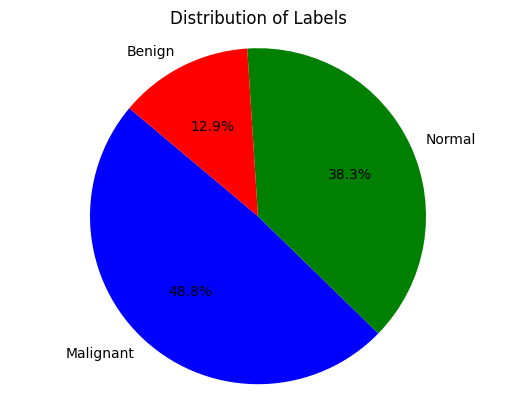

In [ ]:
from matplotlib import pyplot as plt

# Assuming metadata is a DataFrame with a column named 'label'
label_counts = metadata['label'].value_counts()
custom_colors = ['blue', 'green', 'red', 'purple', 'orange']  # Specify your custom colors here

plt.pie(label_counts, labels=label_counts.index, colors=custom_colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Labels')
plt.show()


> example of preprocessing results

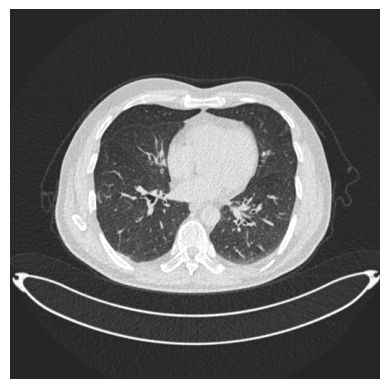

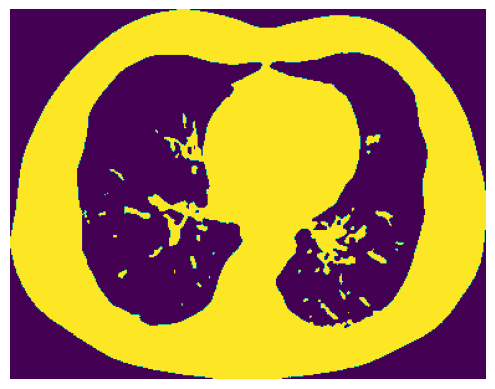

In [ ]:
#load one of the images from the 'Benign' folder
input_image_path = '/content/drive/MyDrive/Lung_Cancer/dataset/Benign/Bengin case (10).jpg'
input_image = plt.imread(input_image_path)

#displays images

plt.imshow(input_image)
plt.axis('off')
plt.show()

#perform denoising and segmentation
#input_image=cv2.medianBlur(input_image,5)
#input_image=cv2.GaussianBlur(input_image,(3,3),0)

gray_image_uint = segment_image(input_image)

#displays images that have been preprocessed
print ("\n")
plt.imshow(gray_image_uint)
plt.axis('off')
plt.show()


In [ ]:
input_image_path = '/content/drive/MyDrive/Lung_Cancer/dataset/Malignant/Copy of Malignant case (444).jpg'
input_image = plt.imread(input_image_path)

input_image.shape

(512, 512, 3)

# Feature Extraction

# Create a function for feature extraction with **LBP**


In [ ]:
import numpy as np
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, num_points=8, radius=1, method='uniform', normalize=True):
    # Calculate LBP
    lbp = local_binary_pattern(image, num_points, radius, method)

    # Calculate histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))

    # Normalize histogram if required
    if normalize:
        hist = hist.astype(np.float32)
        hist /= hist.sum()

    return hist

> Feature Extraction from entire Image





In [ ]:
X = []
y = []

from skimage import color

for index, row in metadata.iterrows():
  segmented_image = row['segmented_image']

  features = extract_lbp_features(segmented_image)
  X.append(features)
  y.append(row['label'])

> convert to numpy array

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape,y.shape

((1399, 10), (1399,))

#Classification and Analysis

# divide the dataset into two, namely train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_en_train=le.fit_transform(y_train)

In [ ]:
y_en_train

array([2, 0, 0, ..., 2, 1, 2])

> 1. classification and analysis with **SVM algorithm**



In [ ]:
#from sklearn.inspection import DecisionBoundaryDisplay
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("SVM Accuracy:", accuracy)
print("SVM Confusion Matrix:")
print(conf_matrix)

SVM Accuracy: 0.5285714285714286
SVM Confusion Matrix:
[[  0  30   0]
 [  0 148   0]
 [  0 102   0]]


> 3. classification and analysis with **Decision Tree**


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Confusion Matrix:")
print(conf_matrix)

Decision Tree Accuracy: 0.825
Decision Tree Confusion Matrix:
[[ 20   0  10]
 [  6 128  14]
 [  4  15  83]]


> 4. classification and analysis with **Random Forest**


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Random Forest Accuracy:", accuracy)
print("Random Forest Confusion Matrix:")
print(conf_matrix)
print("Random Forest Classification Report:")
print(classification_rep)

Random Forest Accuracy: 0.8535714285714285
Random Forest Confusion Matrix:
[[ 17   1  12]
 [  0 133  15]
 [  3  10  89]]
Random Forest Classification Report:
              precision    recall  f1-score   support

      Benign       0.85      0.57      0.68        30
   Malignant       0.92      0.90      0.91       148
      Normal       0.77      0.87      0.82       102

    accuracy                           0.85       280
   macro avg       0.85      0.78      0.80       280
weighted avg       0.86      0.85      0.85       280



In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
          n_estimators=150)
n_folds=5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(rf, X, y, cv=kf)
cross_val_results,cross_val_results.mean()


(array([0.86785714, 0.84285714, 0.84642857, 0.86428571, 0.87455197]),
 0.8591961085509473)

#Predicting type of cancer from Images



by using the classifier with the highest accuracy, namely: Random Forest

original class : **Benign**

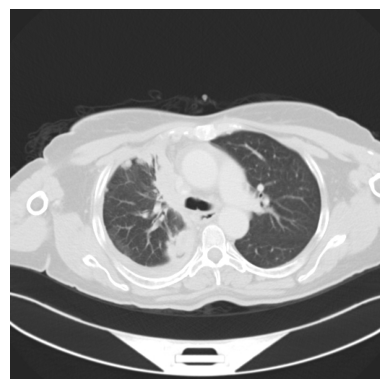

Predicted Class Label: Malignant


In [ ]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from skimage.transform import resize
import numpy as np

from sklearn.ensemble import RandomForestClassifier
rf.fit(X_train, y_train)
#take image with original class 'no'
# input_image_path = '/content/drive/MyDrive/Lung_Cancer/dataset/Benign/Bengin case (101).jpg'
input_image_path = '/content/drive/MyDrive/Lung_Cancer/dataset/Malignant/Copy of Malignant case (445).jpg'
input_image = plt.imread(input_image_path)

#display image

plt.imshow(input_image)
plt.axis('off')
plt.show()

#preprocessing and feature extraction
segmented_image = segment_image(input_image)
features = extract_lbp_features(segmented_image)

#change features to match Random Forest Classifier
example_features = features.reshape(1, -1)

#predict labels

predicted_label = rf.predict(example_features)[0]

print("Predicted Class Label:", predicted_label)


Cancer Class: **Malignant**

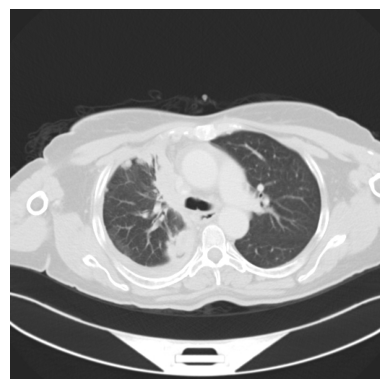

Predicted Class Label: Malignant


In [ ]:
#example if the input image is to predict the class
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from skimage.transform import resize
import numpy as np

from sklearn.ensemble import RandomForestClassifier
rf.fit(X_train, y_train)

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/Lung_Cancer/dataset/Malignant/Copy of Malignant case (445).jpg'
input_image = plt.imread(input_image_path)

# Display the image
plt.imshow(input_image)
plt.axis('off')
plt.show()

#preprocessing and feature extraction
segmented_image = segment_image(input_image)
features = extract_lbp_features(segmented_image)

#changing features to match the Random Forest Classifier
example_features = features.reshape(1, -1)

#predict labels

predicted_label = rf.predict(example_features)[0]

print("Predicted Class Label:", predicted_label)


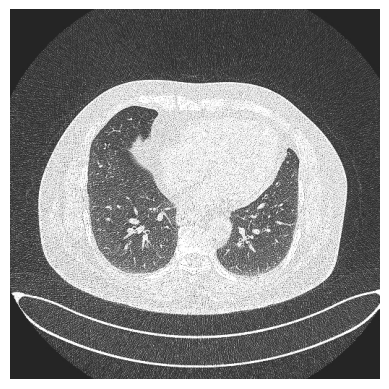

Predicted Class Label: Malignant


In [ ]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from skimage.transform import resize
import numpy as np
from sklearn.svm import SVC

# Initialize the SVM classifier
svm = SVC()
svm.fit(X_train, y_train)

# Fit the SVM classifier to your training data (X_train, y_train)

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/Lung_Cancer/dataset/Benign/Bengin case (101).jpg'
input_image = plt.imread(input_image_path)

# Display the image
plt.imshow(input_image)
plt.axis('off')
plt.show()

# Preprocessing and feature extraction
segmented_image = segment_image(input_image)
features = extract_lbp_features(segmented_image)

# Reshape features to match the classifier's input format
example_features = features.reshape(1, -1)

# Predict labels using the SVM classifier
predicted_label = svm.predict(example_features)[0]

print("Predicted Class Label:", predicted_label)
